# Rossman sales

## 1. Adatbázis beolvasása

In [14]:
import pandas as pd
train = pd.read_csv('rossman_train.csv') # napi arbevetel adatok
test = pd.read_csv('rossman_test.csv')
store = pd.read_csv('store.csv') 

In [15]:
# Imputáláshoz kapcsoljuk össze az adatbázisokat
train["validation"] = "train"
test["validation"] = "test"
frames = [train, test]
df_temp = pd.concat(frames, sort = False)
df = pd.merge(left = df_temp, right = store, how = "left", on='Store')

## 2. Adattisztítás és feltáró elemzés

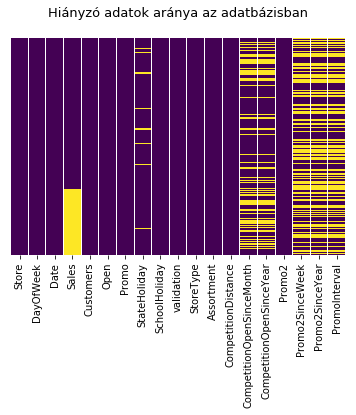

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = 'viridis') # 1 perc
plt.title('Hiányzó adatok aránya az adatbázisban\n', fontsize = 13) 
plt.show()

Összesen hét prediktorban voltak hiányzó értékek (a 7. a Promo2).

In [4]:
# Hiányzó adatok imputálása
df["StateHoliday"].fillna(1, inplace = True) # keresztény ünnepek és German Re-unificationd day
df.fillna({'Promo2SinceWeek': 0, 'Promo2SinceYear': 0, 'PromoInterval': 0}, inplace=True)
df["CompetitionDistance"].fillna(df["CompetitionDistance"].mean(), inplace = True)
df["CompetitionOpenSinceMonth"].fillna(df["CompetitionOpenSinceMonth"].mean(), inplace = True) 
df["CompetitionOpenSinceYear"].fillna(df["CompetitionOpenSinceYear"].mean(), inplace = True)

In [5]:
# Kategoriális változók dummizása

# manage date
df['Date'] = df['Date'].astype('datetime64[ns]')

# extract date
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df.drop(columns=['Date'], inplace = True)

# tovabbi kategorialis valtozok
df = pd.get_dummies(df, columns=['StoreType', 'Assortment'], drop_first=False)

# PromoInterval változó karaktereiet dummizzuk (3 perc mig lefut az alabbi nested loop)
df[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]] = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0]], index=df.index)
ho = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for c in range(len(df.index)):
    s = df.loc[df.index[c], "PromoInterval"]
    if s != 0:
        try:
            s2 = s.split(',')
            for m in ho:
                try:
                    if m in s2:
                        df.at[df.index[c], m] = 1
                except:
                    pass              
        except:
            pass
    else:
        pass

df.drop(columns=['PromoInterval'], inplace = True)

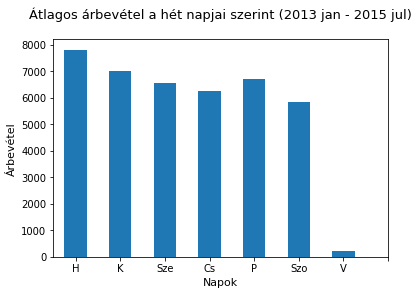

In [6]:
# Keressünk összefüggéseket

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
sm = train.groupby(['DayOfWeek'])['Sales'].mean()
sm.plot(kind = "bar", x='DayOfWeek', y='Sales', rot=0)
plt.title('Átlagos árbevétel a hét napjai szerint (2013 jan - 2015 jul)\n', fontsize = 13) 
plt.ylabel('Árbevétel', fontsize=11)
plt.xlabel('Napok', fontsize=11)
my_xticks = ['H','K','Sze','Cs', 'P', 'Szo', 'V']
x = np.array([0,1,2,3,4,5,6,7])
plt.xticks(x, my_xticks)
plt.show() 

Vasárnap gyakorlatilag nem volt árbevétel.

In [7]:
corr = train[train.columns.difference(['Date', 'validation', 'Assortment', 'PromoInterval', 'StateHoliday'])].corr()
corr.style.background_gradient(cmap='coolwarm') 

,Customers,DayOfWeek,Open,Promo,Sales,SchoolHoliday,Store
Customers,1,-0.38603,0.616877,0.315827,0.894372,0.071604,0.0248201
DayOfWeek,-0.38603,1,-0.528661,-0.393047,-0.462258,-0.205473,-8.54782e-05
Open,0.616877,-0.528661,1,0.295129,0.678819,0.0855698,6.50221e-05
Promo,0.315827,-0.393047,0.295129,1,0.452459,0.0673027,0.000347313
Sales,0.894372,-0.462258,0.678819,0.452459,1,0.0850632,0.00535436
SchoolHoliday,0.071604,-0.205473,0.0855698,0.0673027,0.0850632,1,0.00186405
Store,0.0248201,-8.54782e-05,6.50221e-05,0.000347313,0.00535436,0.00186405,1


Az árbevétel (Sales) leginkább a vásárlók számával (Customers) korrelált (r = 0.89).

In [8]:
# Válasszuk szét az adatbázisokat modellezéshez

del [train, test]
train = df.loc[df["validation"] == "train"]
test = df.loc[df["validation"] == "test"]

train.drop(columns=['validation'], inplace = True)
test.drop(columns=['validation'], inplace = True)
test.drop(columns=['Sales'], inplace = True)
del df

C:\Users\Gabor\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## 3. Döntési fa modellek

In [9]:
# Hiperparaméterek hangolása keresztvalidálással

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import time
from sklearn.preprocessing import RobustScaler

feature_cols = train.columns[~ train.columns.isin(['Sales'])]
X = train[feature_cols] 
y = train["Sales"]

param_grid = {"max_depth": [6, 10],
              "min_samples_split": [20, 100],
              "min_weight_fraction_leaf": [.01, .001]
              }

dt = DecisionTreeRegressor(random_state=3,
                           criterion="mse",
                           min_samples_leaf = 20    
                          ) 

folds = KFold(n_splits = 5, shuffle = True, random_state = 3)

model_cv = GridSearchCV(estimator = dt, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True) 

start = time.time()
model_cv.fit(X, y) # 6 perc mig lefut
stop = time.time()
print(f"Training time: {stop- start} s") 

Training time: 346.56082224845886 s


In [10]:
print("R-Squared::{}".format(round(model_cv.best_score_,2))) # mivel ez nem egy bovitett modell, tan jo lesz az R2.
print("Best Hyperparameters::\n{}".format(model_cv.best_params_))

R-Squared::0.93
Best Hyperparameters::
{'max_depth': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.001}


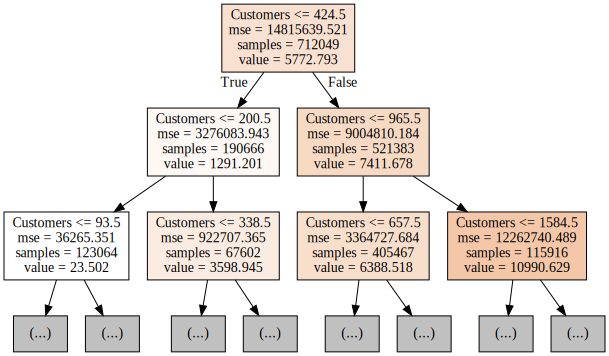

In [11]:
# Vizualizáljuk a döntési fát

# elosszor illeszteni kell a modellt a valasztott hiperparameterekkel, h lefusson a vizu
dt = DecisionTreeRegressor(random_state=3,
                           criterion="mse",
                           max_depth=10, 
                           min_samples_split = 20, 
                           min_samples_leaf = 20,
                           min_weight_fraction_leaf = .001                            
                          ) 
folds = KFold(n_splits = 5, shuffle = True, random_state = 3)
score = cross_val_score(dt, X, y, cv=folds, scoring = 'r2')
model = dt.fit(X, y)
y_pred = dt.predict(X)

import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(model, out_file=None, filled=True, feature_names=X.columns.values, max_depth=2) 
graph = graphviz.Source(dot_data)
graph.format = "png" #x mentsuk is el
graph.render("tree")
graph

## 4. Prediktáljunk a teszthalmazon

In [12]:
feature_cols_t = test.columns
X_test = test[feature_cols_t] 
n = len(X_test.index)
X_test.dtypes
X_test.isnull().sum()
y_pred_t = dt.predict(X_test)

In [13]:
# Mentsuk el a tanulóhalmazon prediktált Sales értékeket

features = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday','SchoolHoliday']
final = test[features].copy()
final["Sales"] = y_pred_t
final.Sales = round(final.Sales,3)
final.to_csv("test_w_sales.csv", index=False)

In [19]:
# Gyors ellenőrzés: a predikciók megfelelnek annak, amit várnánk

m1 = round(train[["Sales", "Customers"]].corr(),2).iloc[0,1]
print("Sales és Customer közti korreláció értéke a tanulóhalmazon:", m1)

m2 = round(final[["Sales", "Customers"]].corr(),2).iloc[0,1]
print("Sales és Customer közti korreláció értéke a teszthalmazon:", m2)

Sales és Customer közti korreláció értéke a tanulóhalmazon: 0.89
Sales és Customer közti korreláció értéke a teszthalmazon: 0.92
